In [1]:
### Initialize
import DataFrames, CSV, Plots, JuMP, Gurobi

In [140]:
using JuMP, Gurobi
Hours = 24
Cp = 1.01*1000 #J/kg K
rho = 1.225
Vol = 482.3
SA = 220
MassAir = Vol*rho
U = 0.3 ## W/m2K
UA = SA*U  #W/K
JoulesLost = UA*3600 #J/K

6*MassAir*Cp/3600/1000

0.9945427916666668

In [126]:
Cost = [0.0444,0.0444,0.0444,0.0444,0.0444,0.0444,0.0444,0.0444,0.0444,0.05413,0.05413,0.05413,0.05413,0.05413,0.05413,     0.0888, 0.0888, 0.0888, 0.0888, 0.0888,0.05413,0.05413,0.05413,0.05413]
PeopleE = [1.266624e+06,1.266624e+06,1.266624e+06,1.266624e+06,1.266624e+06,1.266624e+06,1.266624e+06,
    1.118556e+06,5.175552e+05,3.063837e+05,3.063837e+05,3.063837e+05,3.063837e+05,3.063837e+05,3.063837e+05,
     3.063837e+05,3.736287e+05,7.005697e+05, 1.136073e+06,1.136073e+06,1.136073e+06,1.266624e+06,1.266624e+06,1.266624e+06] ##J
# ## Losses
Qloss = [1000,1000, 1000, 1000, 1000, 1000, 1000, 1000,
    1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000] *1000 ##J

TOutdoor = [1.75,0.6667,-2.16,-2.41,-3.75,-3.83,-3.53,-4,-0.5,6,6,4,4,5.1,5.8,5.3,3.83,0.66,-1,-1,-1,-1,-.416]

23-element Array{Float64,1}:
  1.75
  0.6667
 -2.16
 -2.41
 -3.75
 -3.83
 -3.53
 -4.0
 -0.5
  6.0
  6.0
  4.0
  4.0
  5.1
  5.8
  5.3
  3.83
  0.66
 -1.0
 -1.0
 -1.0
 -1.0
 -0.416

In [127]:
model = Model(Gurobi.Optimizer)

Academic license - for non-commercial use only - expires 2022-04-09


A JuMP Model
Feasibility problem with:
Variables: 0
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: Gurobi

In [128]:
##Define Variables 
@variable(model,TSetpoint[1:Hours],container=Array)
@variable(model, TZone[1:Hours], container=Array)
@variable(model, Qsys[1:Hours], container=Array)
#@variable(model, UALoss[1:Hours], container=Array)
@variable(model, HeatingOn[1:Hours], binary=true)

24-element Array{VariableRef,1}:
 HeatingOn[1]
 HeatingOn[2]
 HeatingOn[3]
 HeatingOn[4]
 HeatingOn[5]
 HeatingOn[6]
 HeatingOn[7]
 HeatingOn[8]
 HeatingOn[9]
 HeatingOn[10]
 HeatingOn[11]
 HeatingOn[12]
 HeatingOn[13]
 HeatingOn[14]
 HeatingOn[15]
 HeatingOn[16]
 HeatingOn[17]
 HeatingOn[18]
 HeatingOn[19]
 HeatingOn[20]
 HeatingOn[21]
 HeatingOn[22]
 HeatingOn[23]
 HeatingOn[24]

In [129]:
##Q needed 
for i in 2:Hours
    Qsys[i] == HeatingOn[i]*(TSetpoint[i]-TZone[i-1])*MassAir*Cp ##J Joules
end

In [130]:
# ##Q needed 
# for i in 1:Hours-1
#    UALoss[i] == (TOutdoor[i]-TZone[i])*JoulesLost
# end


In [131]:
@constraint(model, [i=2:Hours], TZone[i] == TZone[i-1] + (Qsys[i-1] + PeopleE[i-1] - Qloss[i-1])/MassAir/Cp)
@constraint(model, [i=2:Hours],  Qsys[i] == HeatingOn[i]*(TSetpoint[i]-TZone[i-1])*MassAir*Cp) ##J Joules
@constraint(model, [i=1:Hours],TZone[i]<=24)
@constraint(model, [i=1:Hours],TZone[i]>=19)
@constraint(model, [i=1:Hours],TSetpoint[i]>=18)
@constraint(model, [i=1:Hours],TSetpoint[i]<=25)
@constraint(model,[i=1:Hours],Qsys[i]>=0)

24-element Array{ConstraintRef{Model,MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64},MathOptInterface.GreaterThan{Float64}},ScalarShape},1}:
 Qsys[1] >= 0.0
 Qsys[2] >= 0.0
 Qsys[3] >= 0.0
 Qsys[4] >= 0.0
 Qsys[5] >= 0.0
 Qsys[6] >= 0.0
 Qsys[7] >= 0.0
 Qsys[8] >= 0.0
 Qsys[9] >= 0.0
 Qsys[10] >= 0.0
 Qsys[11] >= 0.0
 Qsys[12] >= 0.0
 Qsys[13] >= 0.0
 Qsys[14] >= 0.0
 Qsys[15] >= 0.0
 Qsys[16] >= 0.0
 Qsys[17] >= 0.0
 Qsys[18] >= 0.0
 Qsys[19] >= 0.0
 Qsys[20] >= 0.0
 Qsys[21] >= 0.0
 Qsys[22] >= 0.0
 Qsys[23] >= 0.0
 Qsys[24] >= 0.0

In [132]:
## Minimize Total Cost
TotalCost= sum(Cost.*Qsys/3600/1000)  ##convert to kwh
print(TotalCost)
@objective(model, Min, TotalCost)

1.2333333333333335e-8 Qsys[1] + 1.2333333333333335e-8 Qsys[2] + 1.2333333333333335e-8 Qsys[3] + 1.2333333333333335e-8 Qsys[4] + 1.2333333333333335e-8 Qsys[5] + 1.2333333333333335e-8 Qsys[6] + 1.2333333333333335e-8 Qsys[7] + 1.2333333333333335e-8 Qsys[8] + 1.2333333333333335e-8 Qsys[9] + 1.503611111111111e-8 Qsys[10] + 1.503611111111111e-8 Qsys[11] + 1.503611111111111e-8 Qsys[12] + 1.503611111111111e-8 Qsys[13] + 1.503611111111111e-8 Qsys[14] + 1.503611111111111e-8 Qsys[15] + 2.466666666666667e-8 Qsys[16] + 2.466666666666667e-8 Qsys[17] + 2.466666666666667e-8 Qsys[18] + 2.466666666666667e-8 Qsys[19] + 2.466666666666667e-8 Qsys[20] + 1.503611111111111e-8 Qsys[21] + 1.503611111111111e-8 Qsys[22] + 1.503611111111111e-8 Qsys[23] + 1.503611111111111e-8 Qsys[24]

1.2333333333333335e-8 Qsys[1] + 1.2333333333333335e-8 Qsys[2] + 1.2333333333333335e-8 Qsys[3] + 1.2333333333333335e-8 Qsys[4] + 1.2333333333333335e-8 Qsys[5] + 1.2333333333333335e-8 Qsys[6] + 1.2333333333333335e-8 Qsys[7] + 1.2333333333333335e-8 Qsys[8] + 1.2333333333333335e-8 Qsys[9] + 1.503611111111111e-8 Qsys[10] + 1.503611111111111e-8 Qsys[11] + 1.503611111111111e-8 Qsys[12] + 1.503611111111111e-8 Qsys[13] + 1.503611111111111e-8 Qsys[14] + 1.503611111111111e-8 Qsys[15] + 2.466666666666667e-8 Qsys[16] + 2.466666666666667e-8 Qsys[17] + 2.466666666666667e-8 Qsys[18] + 2.466666666666667e-8 Qsys[19] + 2.466666666666667e-8 Qsys[20] + 1.503611111111111e-8 Qsys[21] + 1.503611111111111e-8 Qsys[22] + 1.503611111111111e-8 Qsys[23] + 1.503611111111111e-8 Qsys[24]

In [133]:
optimize!(model)

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 143 rows, 96 columns and 189 nonzeros
Model fingerprint: 0x961e248f
Model has 23 quadratic constraints
Variable types: 72 continuous, 24 integer (24 binary)
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  QMatrix range    [6e+05, 6e+05]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e-08, 2e-08]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 3e+01]
Presolve removed 120 rows and 4 columns
Presolve time: 0.00s
Presolved: 184 rows, 138 columns, 481 nonzeros
Variable types: 115 continuous, 23 integer (23 binary)

Root relaxation: objective 4.801348e-02, 18 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.04801    0    3          -    0.04801      -     -    0s
H 

In [134]:
TSetpoint_Opt= JuMP.value.(TSetpoint)
Qsys_Opt = JuMP.value.(Qsys)
OnOff_Opt= JuMP.value.(HeatingOn)
# print(TSetpoint_Optimized)
TZone_Opt = JuMP.value.(TZone)
# print(OnOff)
print(TSetpoint_Opt)

[18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 24.609809189121954, 18.0, 18.0, 18.0, 18.0, 25.0, 19.55146935817704, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0]

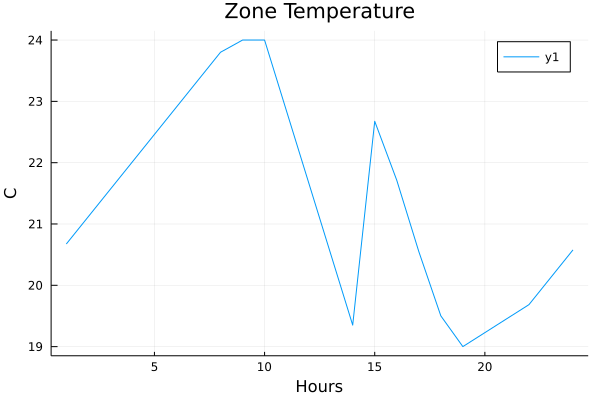

In [135]:
##Indoor T
using Plots
x = 1:Hours
plot(x,TZone_Opt, title = "Zone Temperature")
xlabel!("Hours")
ylabel!("C")


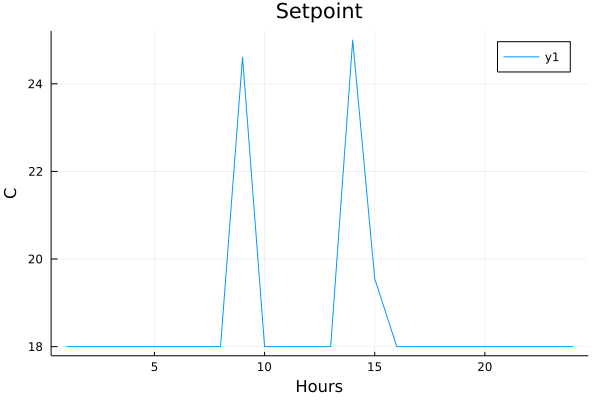

In [136]:
##Indoor T
using Plots
x = 1:Hours
plot(x,TSetpoint_Opt, title = "Setpoint")
xlabel!("Hours")
ylabel!("C")

In [137]:
ActualSet = OnOff_Opt .* TSetpoint_Opt

24-element Array{Float64,1}:
  0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 24.609809189121954
 -0.0
 -0.0
 -0.0
 -0.0
 25.0
 19.55146935817704
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0

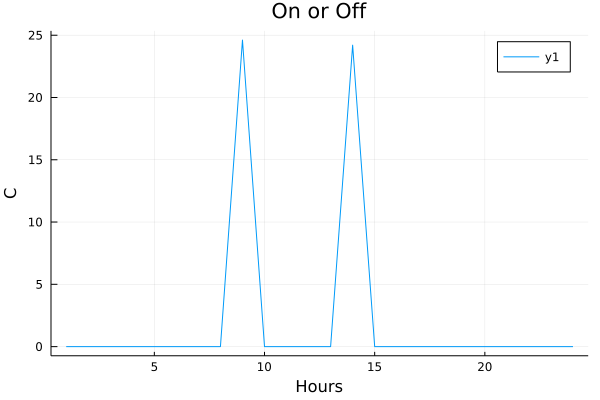

In [60]:
##Indoor T
using Plots
x = 1:Hours
plot(x,ActualSet, title = "On or Off")
xlabel!("Hours")
ylabel!("C")


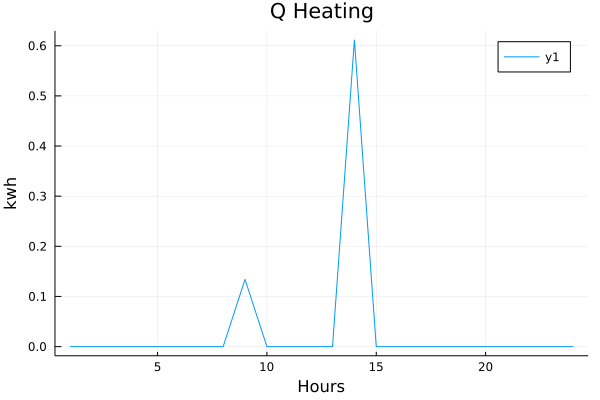

In [53]:
##Indoor T
using Plots
x = 1:Hours
plot(x,Qsys_Opt/3600/1000, title = "Q Heating")
xlabel!("Hours")
ylabel!("kwh")